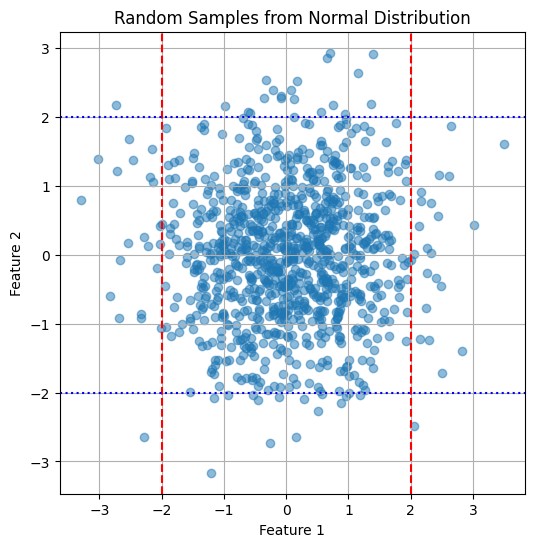

In [9]:
# 正态分布：X~N(μ, δ^2)即期望μ和方差δ^2，δ为标准差。
# 期望μ：代表函数对称轴位置；
# 方差δ^2：高矮胖瘦。方差越小则数据集中，函数高瘦；
# torch.normal(mean, std, size=None, *, out=None) -> Tensor：生成的随机数集中在均值 0 附近，符合标准正态分布。
%matplotlib inline
import torch
import matplotlib.pyplot as plt

# 生成服从标准正态分布的随机数据
data = torch.normal(0, 1, (1000, 2))  # 生成1000个样本，每个样本有2个特征

# 提取数据的第一列和第二列作为x和y坐标
x = data[:, 0]
y = data[:, 1]

# 绘制散点图
plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.5)  # 设置透明度为0.5，使得散点更加清晰可见
plt.axvline(x=2, color='r', linestyle='--', label='x = 2')
plt.axvline(x=-2, color='r', linestyle='--', label='x = -2')
plt.axhline(y=2, color='b', linestyle=':', label='y = 2')
plt.axhline(y=-2, color='b', linestyle=':', label='y = -2')
plt.title('Random Samples from Normal Distribution')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()


In [3]:
# 从零开始实现线性回归方程模型，此处较为复杂，可跳过，到此文档最后有使用深度学习框架来简洁地实现线性回归模型。

In [4]:
# 矩阵乘法：torch.matmul(X, w), (n*l,l*1)=(n*1)

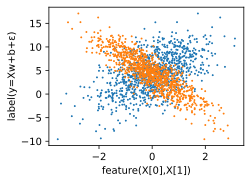

In [5]:
import torch
'''线性回归的数据集生成'''
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    # 线性回归方程，也可以用mv函数计算Xw矩阵乘法。
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
# features:随机生成X样本，labels：样本对应的y结果
features, labels = synthetic_data(true_w, true_b, 1000)

# 把数据集绘制出来，方便观察。
%matplotlib inline
import random
import torch
from d2l import torch as d2l
d2l.set_figsize()
d2l.plt.xlabel('feature(X[0],X[1])') # 根据正态分布生成的点集
d2l.plt.ylabel('label(y=Xw+b+ε)') # 添加噪声后的结果
d2l.plt.scatter(features[:, 0].detach().numpy(), labels.detach().numpy(), 1); # labels[i]= features[i][0]*w[0]+b+噪声
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1); # labels[i]= features[i][1]*w[1]+b+噪声

In [6]:
print(list(range(4))) # 等价arange函数，但是range是惰性生成器
print(torch.arange(4))

def data_iter(batch_size, features, labels): # features：每行代表一个样本的特征。labels：每行代表一个样本的标签值。
    '''将训练样本分成size个batch训练，返回值并不是单个值，而是一个生成器对象。'''
    num_examples = len(features)
#     indices = list(range(num_examples))
    indices = torch.arange(num_examples) # 0~num-1
    random.shuffle(indices) # 随机打乱索引列表，使得样本读取顺序是随机的
    for i in range(0, num_examples, batch_size): # for i in [0，batch_size,2*batch_size...]
        batch_indices = indices[i: min(i + batch_size, num_examples)] # indices中的i~i+batch_size的乱序下标列表。
        # (batch_size, num_features)、(batch_size,)；执行到 yield 语句时，会返回 yield 这一批次的值，并暂停函数的执行状态。
        yield features[batch_indices], labels[batch_indices]

[0, 1, 2, 3]
tensor([0, 1, 2, 3])


In [7]:
# 循环访问迭代器(生成器)对象
batch_size = 10
print(features.shape, '\n', labels.shape)

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y) # 只打印第一个批次的数据，1000/10=100个。
    break

torch.Size([1000, 2]) 
 torch.Size([1000, 1])
tensor([[ 0.8351, -0.3681],
        [-0.0898, -0.3761],
        [-1.1483,  0.3539],
        [-0.0898, -0.3761],
        [-1.3386,  0.2352],
        [-0.0898, -0.3761],
        [-1.1483,  0.3539],
        [-0.2437,  0.0088],
        [-1.1483,  0.3539],
        [ 0.7520, -0.7356]]) 
 tensor([[7.1181],
        [5.3077],
        [0.6917],
        [5.3077],
        [0.7256],
        [5.3077],
        [0.6917],
        [3.6718],
        [0.6917],
        [8.2038]])


In [10]:
# print(features.shape, labels.shape, 'batch_size:', batch_size, '\nw^T:', true_w.T, 'b:', true_b)

# 1.随机初始化一组参数，之后持续更新直到拟合。
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print('init w.T,b:', w.T, b)

# 2.定义模型
def linreg(X, w, b):  #@save
    """线性回归模型y= Xw+b"""
    return torch.matmul(X, w) + b

# 3.定义损失函数(参数：y_hat 是模型的预测值，y 是真实标签)
def squared_loss(y_hat, y):  #@save
    """均方损失(最小二乘法)：不需要严格按照均方误差的形式来定义损失函数(~/len(y))"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2 # y.reshape(y_hat.shape)预测值和真实值保持同形状。

# 4.定义优化算法
def sgd(params, lr, batch_size):  #@save
    """基于小批量（mini-batch）的随机梯度下降（沿着损失函数的负梯度方向调整参数）"""
    with torch.no_grad(): # 在其内部的代码块中不计算梯度信息
        for param in params: # [w,b]作为数组遍历操作
#             if len(param)>1:
#                 print('grad:', param.grad.T)
            # 3.1.1.2 公式详解:1/(2n)∑(y-yi)^2=1/(2n)∑(Xw+b-yi)^2, 其实就是公式求导.
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            
# 5.训练（待修改）
lr = 0.03 # 步长
num_epochs = 3 # 轮次
net = linreg

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        '''X:(batch_size,feature_num); w(feature_num,); y(batch_size,);'''
        l = squared_loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数

    # 每一轮所有数据训练完之后，用更新后的参数对原有批量数据进行预测。
    with torch.no_grad():
#         print(torch.cat((net(features, w, b), labels), dim=1)) # 将预测结果和labels标记拼接比较
        train_l = squared_loss(net(features, w, b), labels) # 更新参数后，针对所有样本进行一次预测
        # 输出所有预测结果均方损失的平均值。:f 表示使用定点表示法（固定小数点表示法）
        print(f'epoch {epoch + 1},loss {float(train_l.mean()):f}, w is {w.T}, b is {b}')


init w.T,b: tensor([[-0.0080,  0.0073]], grad_fn=<PermuteBackward0>) tensor([0.], requires_grad=True)
epoch 1,loss 0.037413, w is tensor([[ 1.8533, -3.2680]], requires_grad=True), b is tensor([4.0223], requires_grad=True)
epoch 2,loss 0.000145, w is tensor([[ 1.9913, -3.3971]], requires_grad=True), b is tensor([4.1910], requires_grad=True)
epoch 3,loss 0.000054, w is tensor([[ 1.9999, -3.4001]], requires_grad=True), b is tensor([4.1991], requires_grad=True)


In [56]:
# 使用‘深度学习框架’来简洁地实现上述线性回归模型。（回归问题最终是单个连续数值的输出，将loss定义为预测值和真实值的差）

In [21]:
import numpy as np
import torch
# nn是神经网络的缩写
from torch import nn
from torch.utils import data
from d2l import torch as d2l

# 1.初始化数据
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    #  就等价于 TensorDataset(features, labels)
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

# 2.定义模型（单层网络架构， 这一单层被称为全连接层：https://zh.d2l.ai/_images/singleneuron.svg）
net = nn.Sequential(nn.Linear(2, 1))

# 3.初始化模型参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
print(net[0].weight, net[0].bias)

# 4.定义均方误差（损失函数）
loss = nn.MSELoss()
# loss = nn.MSELoss(reduction=‘sum’)/batch_size
# 5.定义优化算法：小批量随机梯度下降算法（学习率：lr）
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

# 6.训练
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y) # 这行代码会执行loss函数，返回值为l。
#         with torch.no_grad():
#             testLoss= nn.MSELoss(reduction='sum')
#             print(l, ' ==', testLoss(net(X), y)/batch_size)
        trainer.zero_grad()
        l.backward() # 标量！
        trainer.step() # 执行了参数的更新操作(with torch.no_grad():)
#     with torch.no_grad():
    # 针对全部数据进行一次预测
    l = loss(net(features), labels)
    # :f 表示使用定点表示法（固定小数点表示法）
    print(f'epoch {epoch + 1}, loss {l:f}')

Parameter containing:
tensor([[ 0.0158, -0.0017]], requires_grad=True) Parameter containing:
tensor([0.], requires_grad=True)
epoch 1, loss 0.000240
epoch 2, loss 0.000100
epoch 3, loss 0.000100


In [1]:
# 损失函数 & 信息论基础

# 估计所有可能类别的条件概率
# 分类问题（Softmax回归）：多个输出，代表第i类的置信度。
# o= Wx+b
#     o(q*1)输出(预测结果oi)为q个; W(q*d)特征维度（输入数量xi）为d; b(q*1)

# 小批量样本矢量化
# O= WX+b
#     O(q,n)
#     W(q,d); b(q,1)--广播为(q,n)
#     X(d,n)= <x1, x2, ..., xn>=(特征维度（输入数量）为d，批量大小为n。xi:(d,1))

# Y= softmax(O):对于每列执行幂运算标准化，如对于第 1 列第i行：yi1= exp(oi1)/∑(i=1~q)exp(oi1)
#     Y(q,n)

# 交叉熵相关概念
# 信息量：一件事情从不确定变成确定的难度有多大。
#     求某件事的信息量公式：f(P)=f(P1)+f(P2)=f(P1P2)  ->  f(P)= -logP
# 熵：整个系统对于信息量的期望(E(X)=P*X),熵值H:=∑P*f(P)= -∑P*logP (此处就是交叉熵损失函数！！！！)
# KL散度的前半部分变动部分是交叉熵，事件P有m种情况pi，Q有n种情况qi，H(P,Q)=-∑(1~max(m,n))pi*logqi------P为基准，是P的交叉熵
# 交叉熵应用在神经网络中：pi取值{0,1}是n个输入,qi表示神经网络的结果，pi与qi事件应对应（pi=0则qi表示pi成立的概率）：
#     H(P,Q)= -(∑(1~n)pi*logqi+∑(1~n)(1-pi)*log(1-qi))= -(∑(1~n)xi*logyi+∑(1~n)(1-xi)*log(1-yi))= L(x,y)损失函数！！！！
#     x是输入，只有{0,1}两种情况，yi=NN(xi)是输出。
#     交叉熵在公式上可以等价看作极大似然函数。交叉熵越小，表明两个模型越接近。

# 参考视频：https://www.bilibili.com/video/BV1cP4y1t7cP/?share_source=copy_web&vd_source=e6535f9b38317627951538804d26d26a

In [28]:
# 图像分类数据集
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display() # 设置图像格式

# 通过ToTensor实例将图像数据从PIL类型变换成float32，（转换为张量）
# 并除以255使得所有像素的数值均在0～1之间(归一化处理)->便于深度学习操作，读取，优化。
trans = transforms.ToTensor()
# 如果数据集已经存在于该路径下，它将直接加载；否则，它会下载数据集到该路径。train=True加载训练集。
# trans 是一个包含变换操作的对象或序列，例如数据标准化、数据增强等
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform= trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform= trans, download=True)


In [29]:
len(mnist_train), len(mnist_test), '图像尺寸：', mnist_train[0][0].shape

(60000, 10000, '图像尺寸：', torch.Size([1, 28, 28]))

In [30]:
# 参数labels：int数组，表示分类。
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

# 可视化这些样本(num_rows, num_cols表示axes显示的格式)
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    # _ 可以用来表示一个不需要使用的返回值；scale单位是英寸，1 inches=2.54 cm
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten() # 将二维数组展平成一维数组方便操作
    # enumerate函数用于获取循环索引和对应的值；zip函数用于将axes和imgs中的元素一一对应起来。
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量(Matplotlib 的 imshow 方法需要输入 NumPy 数组或类似的结构)
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        '''ax.axes 时，你实际上是在获取这个单个子图对象的父级，即它所在的整个图形对象（Figure 对象），而不是一个列表。
           因此，ax.axes 和 axes 是两个不同的概念。'''
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        # 不为空
        if titles:
            ax.set_title(titles[i])
    return axes

标签： tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0])


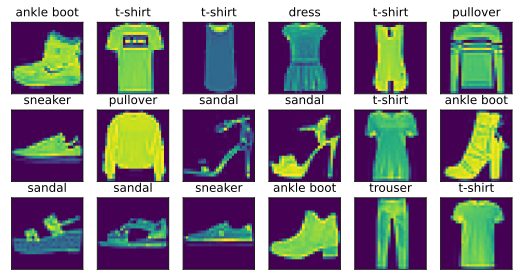

In [47]:
# 将 DataLoader 对象转换为一个迭代器（iterator）。迭代器是一个可以使用 next() 函数逐步获取元素的对象
# 在 PyTorch 中，图像数据通常以 4 维 Tensor 的形式存在，形状为 [batch_size, channels, height, width]
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
print('标签：', y)
show_images(X.reshape(18, 28, 28), 3, 6, titles=get_fashion_mnist_labels(y));

In [32]:
batch_size = 256

# num_workers:使用4个进程来读取数据
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=4)

# 查看遍历数据所需时间
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'5.26 sec'

In [37]:
#  返回训练和测试数据集的 DataLoader 对象（resize像素）
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        # 在转换列表 trans 的最前面插入一个resize操作(短边变为resize像素，长宽比不变)
        trans.insert(0, transforms.Resize(resize))
    '''这样可以将这些转换操作依次应用到数据集的每个图像上
       (接受一个转换操作的列表作为输入，然后将这些转换操作按顺序组合起来，形成一个可以连续应用的序列)'''
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    # 返回两个 DataLoader 对象，一个用于训练集，一个用于测试集
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=4))

In [40]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
# X代表一个batch_size大小的一批数据，y是其对应的label标记列表。
for X, y in train_iter:
    print(X.shape, X.dtype, '\n', y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 
 torch.Size([32]) torch.int64
